### Соловьёв Никита

Регрессия для данных cars moldova

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Создадиим функции для работы с регрессией

In [252]:
# Функция предсказания значений
def forward(weights, inputs):
    return inputs.dot(weights.T)

# Функция потерь
def loss_func(predicts, labels):
    return np.square(predicts - labels)

# Функция градиента ошибки
def grad_loss(predicts, labels, inputs):
    return 2*(predicts - labels) * inputs / inputs.size

# Функция обновления весов
def update_weights(grad, weights, lerning_rate):
    return weights - lerning_rate * grad

# Функция инициализации весов
def weights_init(weights, random_state=42):
    if np.ndim(weights) < 1:
        weights = np.zeros(weights)
    np.random.seed(random_state)
    return np.random.randn(*weights.shape) / np.sqrt(weights.size)

# Функция обучения
def fit(X, y, weights, lr,  epochs=30):
    
    cost = np.zeros(epochs)
    for i in range(epochs): 
        
        grad = np.zeros(weights.shape)
        loss = 0
        
        for m in range(X.shape[0]): 
            yhat  = forward(weights, X[m,:])
            grad += grad_loss(yhat,  y[m], X[m,:])
            loss += loss_func(yhat,  y[m])

        weights = update_weights(grad/X.shape[0],weights, lr)
        cost[i] = loss/X.shape[0]
    
    return weights, cost

# Функция предсказания
def predict(weights, inputs):
    yhat = np.zeros(inputs.shape[0])
    
    for m in range(inputs.shape[0]):
        yhat[m] = inputs[m,:].dot(weights.T)
    
    return yhat

# Функция для построения графика потерь
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15, mfc='none' ); 
    plt.grid()
    plt.xlabel('Эпоха', fontsize=35)
    plt.ylabel('Функция Потерь', fontsize=35)
    plt.xticks()
    plt.yticks()

# Функция расчёта коэффициента детерминации
def r2_score(weights, inputs, labels):
    predicts = predict(weights, inputs)
    return 1 - np.sum(np.square(labels-predicts)) / np.sum(np.square(labels-np.mean(labels)))

def fit_SGD(X, y, weights, lr,  epochs=30, batch_size = 5000, random_state = 42):
    
    np.random.seed(random_state)
    
    cost = np.zeros(epochs)
    for i in range(epochs): 
        
        grad = np.zeros(weights.shape);
        loss = 0;
        
        idx_batch = np.random.randint(0,X.shape[0],batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        y_batch   = np.take(y, idx_batch)

        
        for m in range(batch_size): 
            yhat  = forward(weights, x_batch[m,:])
            grad += grad_loss(yhat,  y_batch[m], x_batch[m,:])
            loss += loss_func(yhat,  y_batch[m])

        weights  = update_weights(grad / batch_size, weights, lr)  
        cost[i] =loss / batch_size
    
    return weights, cost

# Функция визуализации весов
def vis_weigths(weights, names):
    numbers = np.arange(0,len(weights))
    tick_labels = names
    cc = [''] * len(numbers)
    for n, val in enumerate(weights):
        if val < 0:
            cc[n]='red'
        elif val >= 0:
            cc[n] = 'blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0, len(weights)), tick_labels, rotation = 45)

### Объеденим функции в один класс

In [253]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        # если веса и смещения заданы
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #---------------------------------
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

### 1. Необработанные данные

In [254]:
df = pd.read_csv('cars_moldova_clean.csv', delimiter = ',')
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...,...
32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667
32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000
32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714
32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000


Разобъем данные на тренировочные и тестовые

In [255]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  int64  
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1007.0 KB


,0,1,2
22549,0.40,0.011012,0.291667
22550,0.74,0.208921,0.270833
22551,0.84,0.155127,0.270833
22552,0.84,0.219922,0.229167
22553,0.94,0.049905,0.375000


Протестируем функции предсказания и потерь

[-0.1382643   0.02354597 -0.02678343]
-0.0947759167499704 7750.0 7750.09477591675


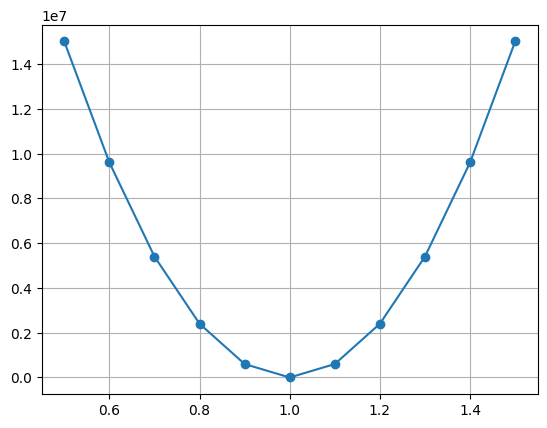

In [256]:
weights = np.random.randn(X.shape[1])
print(weights)
yhat = forward(weights, X_train[0])
loss = np.sqrt(loss_func(yhat, y[0]))
print(yhat, y[0], loss)

decline = np.linspace(start = 0.5, stop = 1.5,num = 11)
yhat = decline* y[0]
loss = loss_func(yhat, y[0])
plt.plot(decline,loss,'-o')
plt.grid()

Рассчитаем градиент ошибки

In [257]:
weights = np.random.randn(X.shape[1])
yhat = forward(weights, X_train[0])
print(weights)
grad = grad_loss(yhat, y[0], X[0])
print(grad)

[ 1.64217358 -0.28563652 -0.54894874]
[-1.03889502e+07 -1.00738204e+09 -9.29891114e+06]


Обновим параметры регрессии

In [258]:
lerning_rate = 0.01
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[  103891.14380939 10073820.11167004    92988.56241101]


Инициализируем веса

In [259]:
weights = weights_init(X_train.shape[1], random_state=42)
weights

array([ 0.28677805, -0.07982693,  0.37394315])

Протестируем обучение

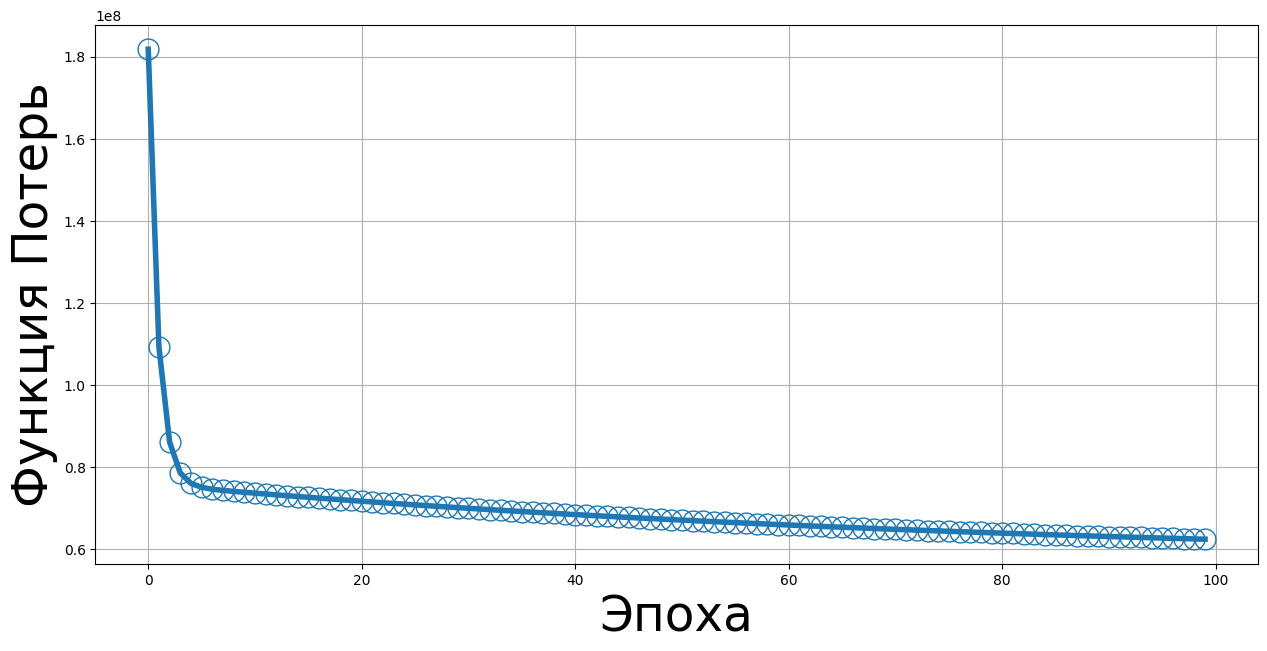

In [260]:
weights = weights_init(X_train.shape[1], random_state=42)
weights, cost = fit(X_train, y_train, weights, lr=0.9,  epochs=100)
fig  = plt.figure(figsize=(15, 7))
plot_cost(cost)

Посмотрим как выглядят наши ответы на фоне реальных

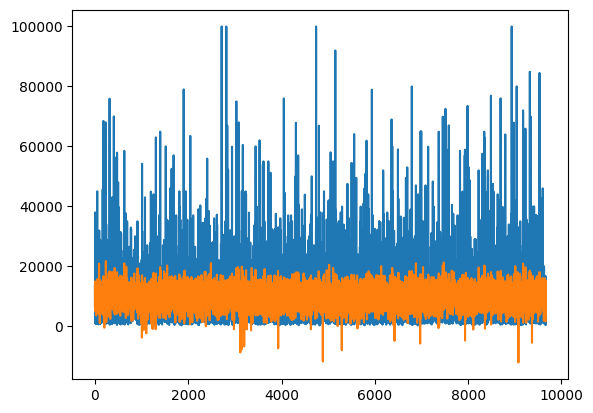

In [261]:
yhat = predict(weights, X_test)
plt.plot(y_test, label='original')
plt.plot(yhat, label='predicted')

Text(0, 0.5, 'predicted')

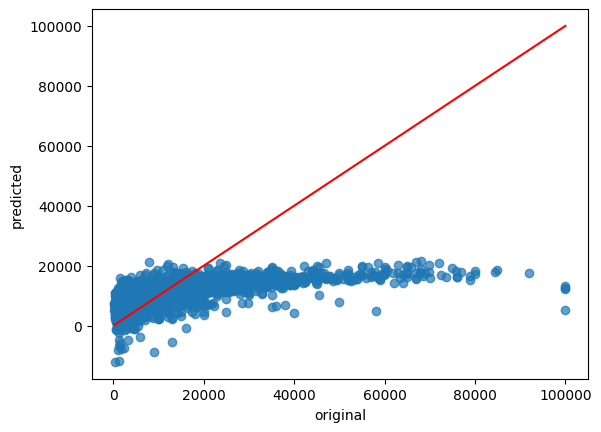

In [262]:
plt.scatter(y_test,yhat,alpha = 0.7)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'r')
plt.xlabel('original')
plt.ylabel('predicted')

In [263]:
# Коэффициент детерменации
r2_score(weights, X_test, y_test)

0.324818580035946

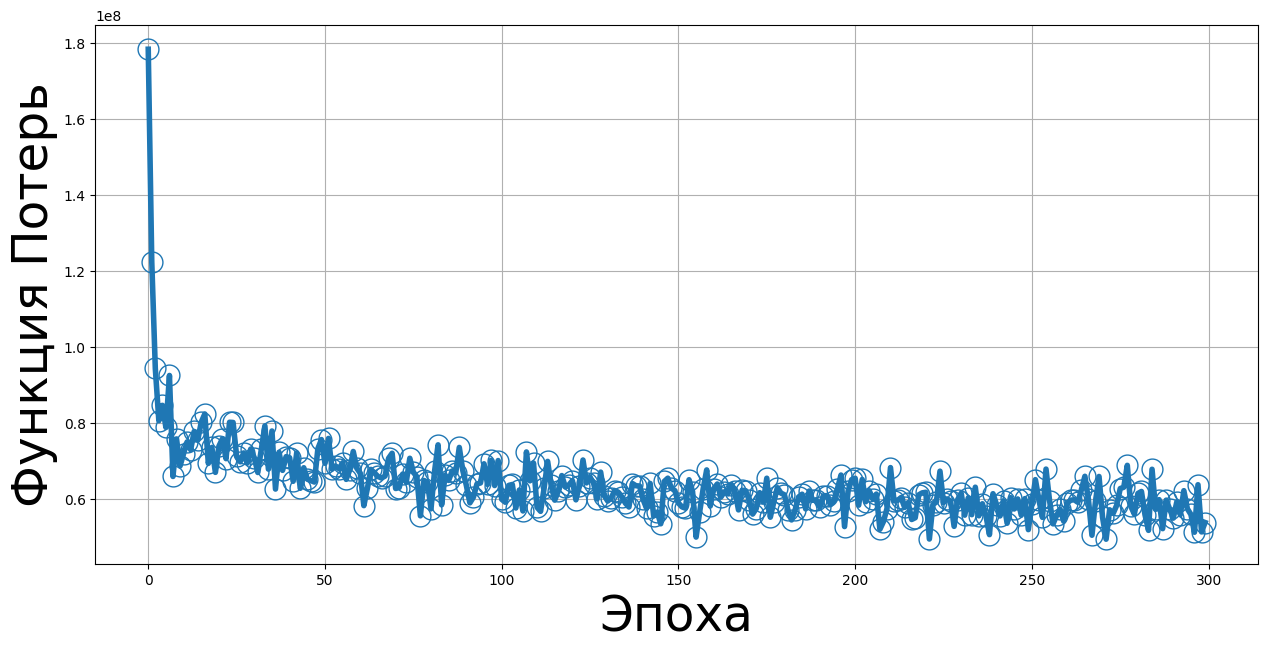

In [264]:
weights = weights_init(X_train.shape[1], random_state=42)
weights, cost = fit_SGD(X_train, y_train, weights, lr=0.7,  epochs=300)
fig  = plt.figure(figsize=(15, 7))
plot_cost(cost)

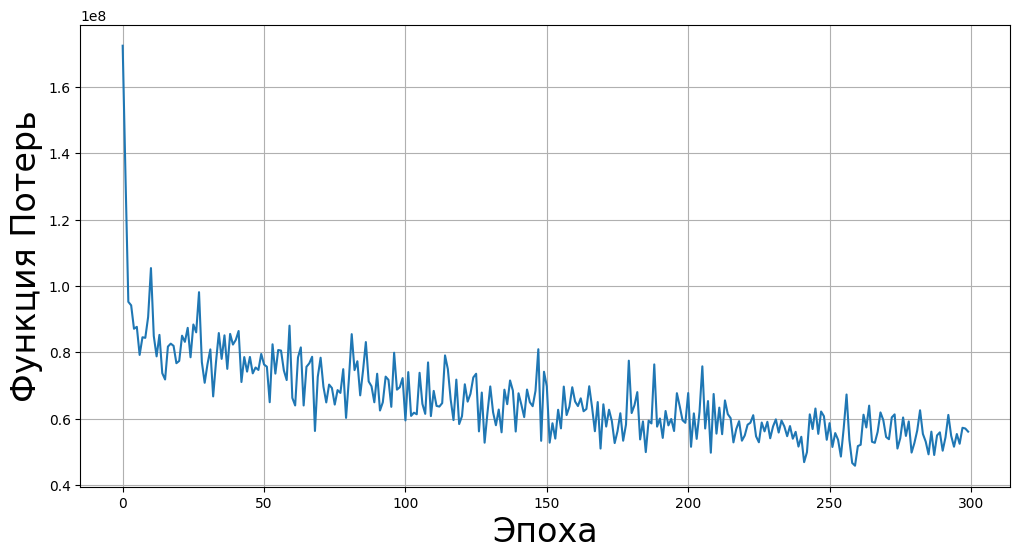

train R2: 0.4082; test R2: 0.4091


In [265]:
regr = LinearRegression(learning_rate=0.1, epochs=300, batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()
print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Визуализруем веса

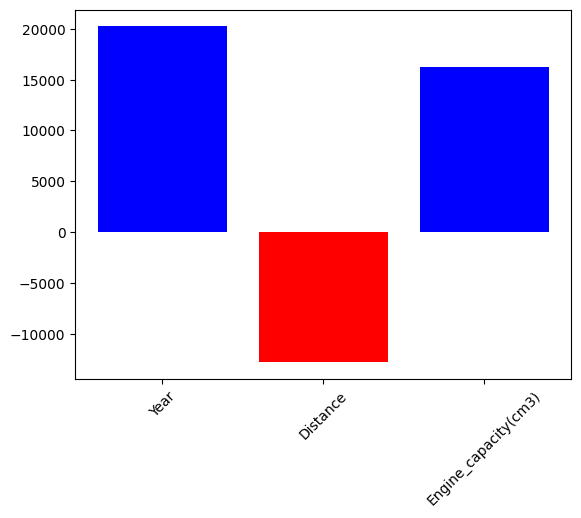

In [266]:
w, b = regr.get_w_and_b()
vis_weigths(w, features_names)

In [267]:
np.sum(np.abs(w))

49291.666139947156

### 2. Нормализованные данные

In [268]:
df = pd.read_csv('cars_moldova_normalization.csv', delimiter = ',')
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),km_year
0,Toyota,Prius,0.714286,Hatchback,0.438013,0.428571,Hybrid,Automatic,0.144737,0.490982
1,Renault,Grand Scenic,0.800000,Universal,0.303136,0.357143,Diesel,Manual,0.160931,0.467241
2,Renault,Laguna,0.742857,Universal,0.246937,0.357143,Diesel,Manual,0.120445,0.303582
3,Opel,Astra,0.571429,Universal,0.449253,0.380952,Metan/Propan,Manual,0.070850,0.345367
4,Mercedes,Vito,0.400000,Microvan,0.674047,0.523810,Diesel,Manual,0.058502,0.377023
...,...,...,...,...,...,...,...,...,...,...
30992,Volkswagen,Passat,0.857143,Sedan,0.197482,0.428571,Petrol,Automatic,0.220648,0.405724
30993,Land Rover,Freelander,0.457143,Crossover,0.505451,0.428571,Metan/Propan,Manual,0.076923,0.310547
30994,Dacia,Logan Mcv,0.828571,Universal,0.199730,0.357143,Diesel,Manual,0.129555,0.351337
30995,Mazda,6,0.571429,Combi,0.831404,0.476190,Diesel,Manual,0.068826,0.641345


Разобъем данные на тренировочные и тестовые

In [269]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30997 entries, 0 to 30996
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  30997 non-null  float64
 1   Distance              30997 non-null  float64
 2   Engine_capacity(cm3)  30997 non-null  float64
 3   Price(euro)           30997 non-null  float64
dtypes: float64(4)
memory usage: 968.8 KB


,0,1,2
21692,0.857143,0.051152,0.238095
21693,0.714286,0.527825,0.476190
21694,0.714286,0.599775,0.285714
21695,0.628571,0.711973,0.523810
21696,0.485714,0.561551,0.523810


Рассчитаем градиент ошибки

In [270]:
weights = np.random.randn(X.shape[1])
yhat = forward(weights, X_train[0])
print(weights)
grad = grad_loss(yhat, y[0], X[0])
print(grad)

[-0.1382643  -1.27468225  0.19138615]
[-0.3528598  -0.21637996 -0.21171588]


Обновим параметры регрессии

In [271]:
lerning_rate = 0.01
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[-0.1347357  -1.27251845  0.19350331]


Инициализируем веса

In [272]:
weights = weights_init(X_train.shape[1], random_state=42)
weights

array([ 0.28677805, -0.07982693,  0.37394315])

Протестируем обучение

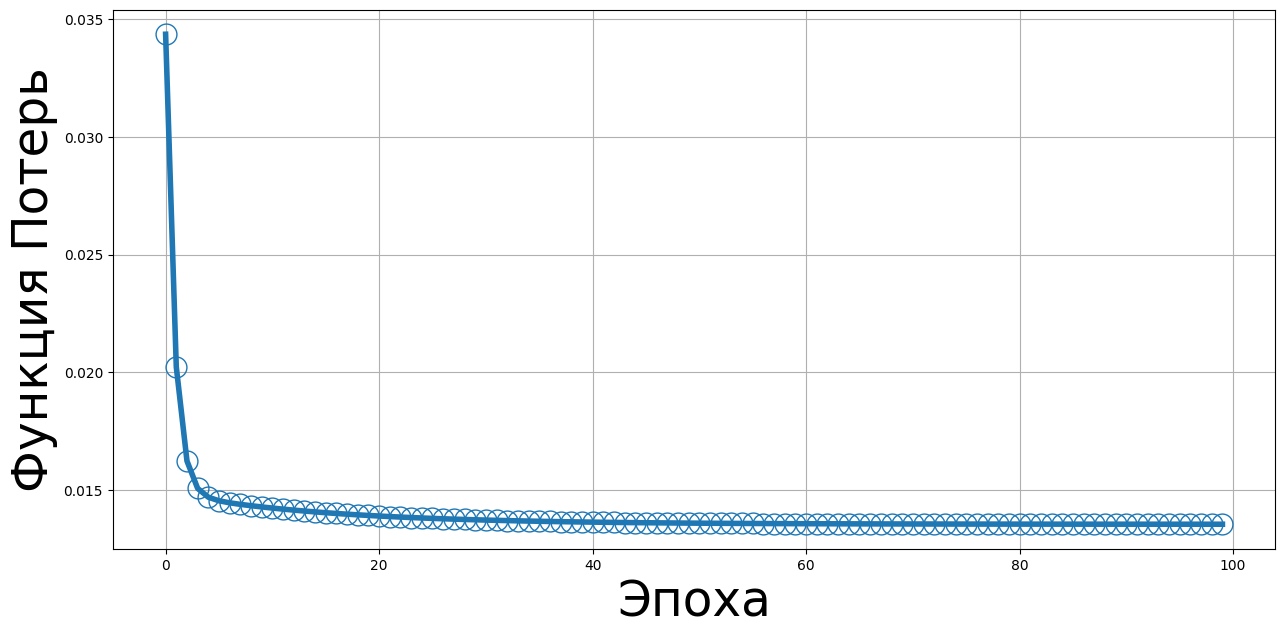

In [273]:
weights = weights_init(X_train.shape[1], random_state=42)
weights, cost = fit(X_train, y_train, weights, lr=0.9,  epochs=100)
fig  = plt.figure(figsize=(15, 7))
plot_cost(cost)

Посмотрим как выглядят наши ответы на фоне реальных

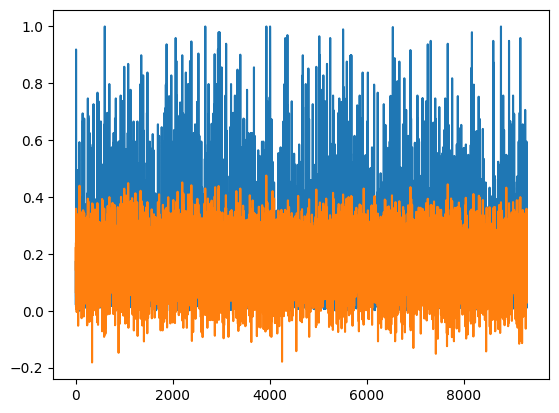

In [274]:
yhat = predict(weights, X_test)
plt.plot(y_test, label='original')
plt.plot(yhat, label='predicted')

Text(0, 0.5, 'predicted')

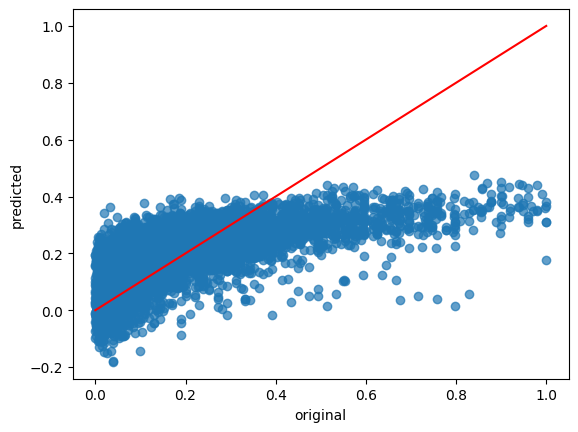

In [275]:
plt.scatter(y_test,yhat,alpha = 0.7)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'r')
plt.xlabel('original')
plt.ylabel('predicted')

In [276]:
# Коэффициент детерменации
r2_score(weights, X_test, y_test)

0.4465177768147107

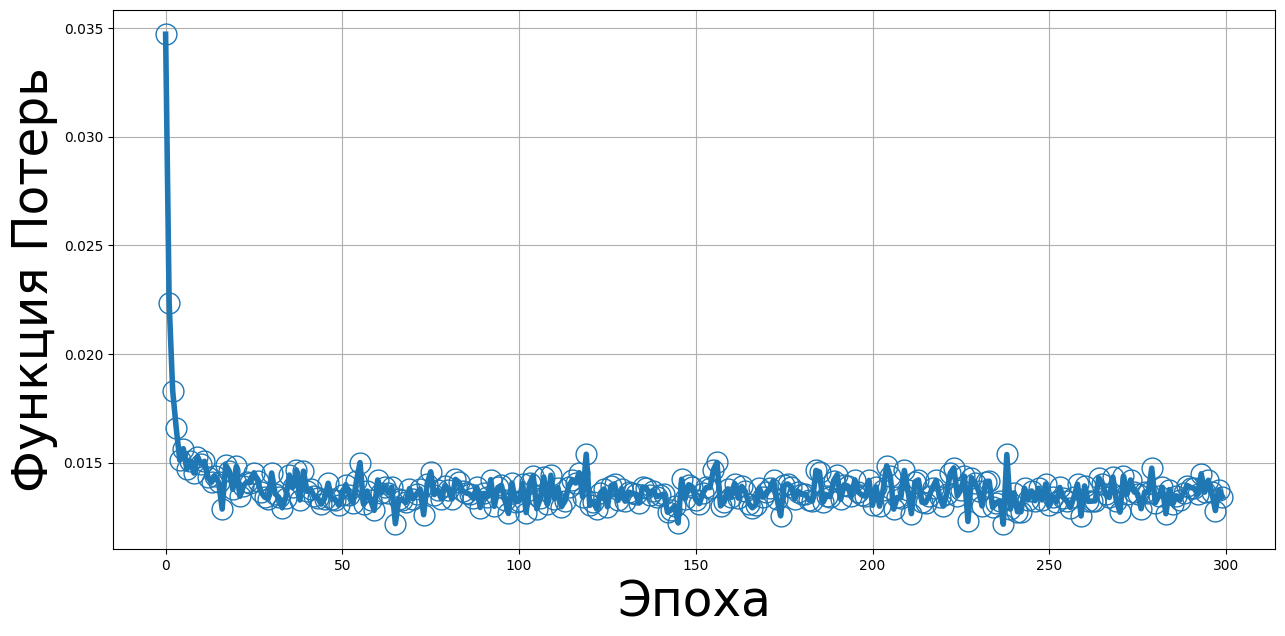

In [277]:
weights = weights_init(X_train.shape[1], random_state=42)
weights, cost = fit_SGD(X_train, y_train, weights, lr=0.7,  epochs=300)
fig  = plt.figure(figsize=(15, 7))
plot_cost(cost)

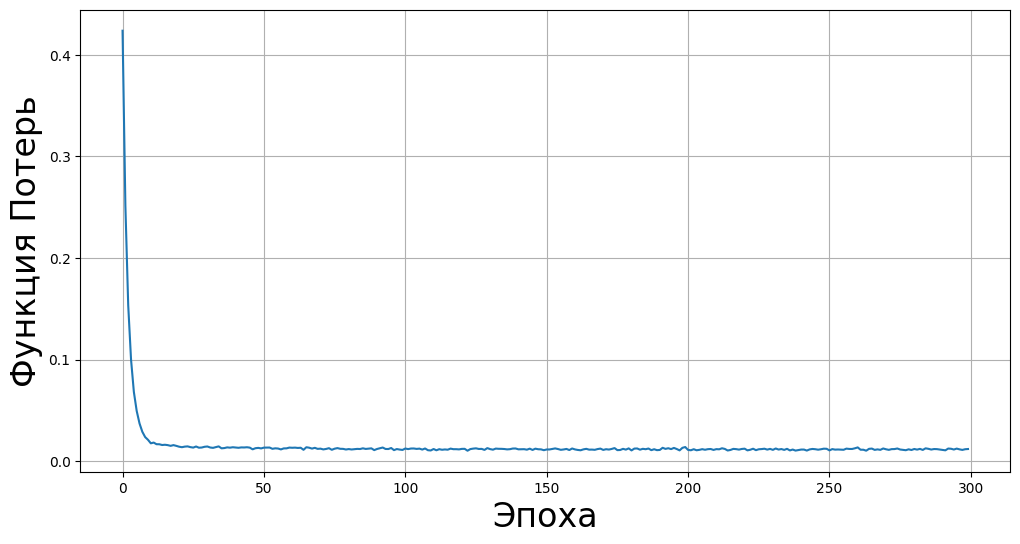

train R2: 0.5211; test R2: 0.5193


In [278]:
regr = LinearRegression(learning_rate=0.5, epochs=300, batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()
print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

**После нормализации точность регрессии значительно повысилась**

Визуализруем веса

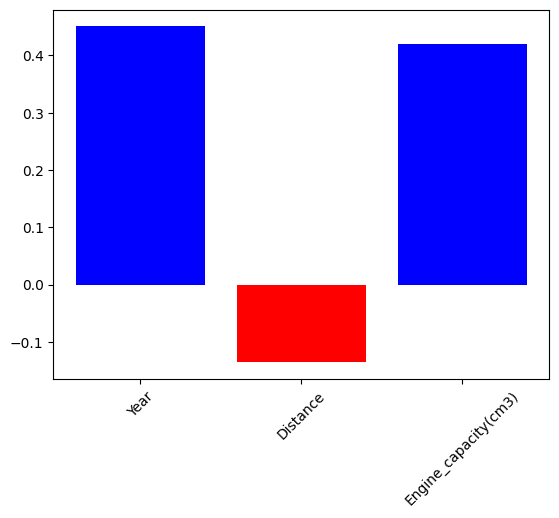

In [279]:
w, b = regr.get_w_and_b()
vis_weigths(w, features_names)

In [280]:
np.sum(np.abs(w))

1.007391158459332

### 3. Стандартизированные данные

In [281]:
df = pd.read_csv('cars_moldova_standardization.csv', delimiter = ',')
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...,...
32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667
32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000
32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714
32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000


Разобъем данные на тренировочные и тестовые

In [282]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  int64  
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1007.0 KB


,0,1,2
22549,0.40,0.011012,0.291667
22550,0.74,0.208921,0.270833
22551,0.84,0.155127,0.270833
22552,0.84,0.219922,0.229167
22553,0.94,0.049905,0.375000


Рассчитаем градиент ошибки

In [283]:
weights = np.random.randn(X.shape[1])
yhat = forward(weights, X_train[0])
print(weights)
grad = grad_loss(yhat, y[0], X[0])
print(grad)

[-0.1382643  -1.34343322 -0.49927748]
[-1.03909144e+07 -1.00757251e+09 -9.30066928e+06]


Обновим параметры регрессии

In [284]:
lerning_rate = 0.01
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[  103909.00571832 10075723.70709485    93006.19349662]


Инициализируем веса

In [285]:
weights = weights_init(X_train.shape[1], random_state=42)
weights

array([ 0.28677805, -0.07982693,  0.37394315])

Протестируем обучение

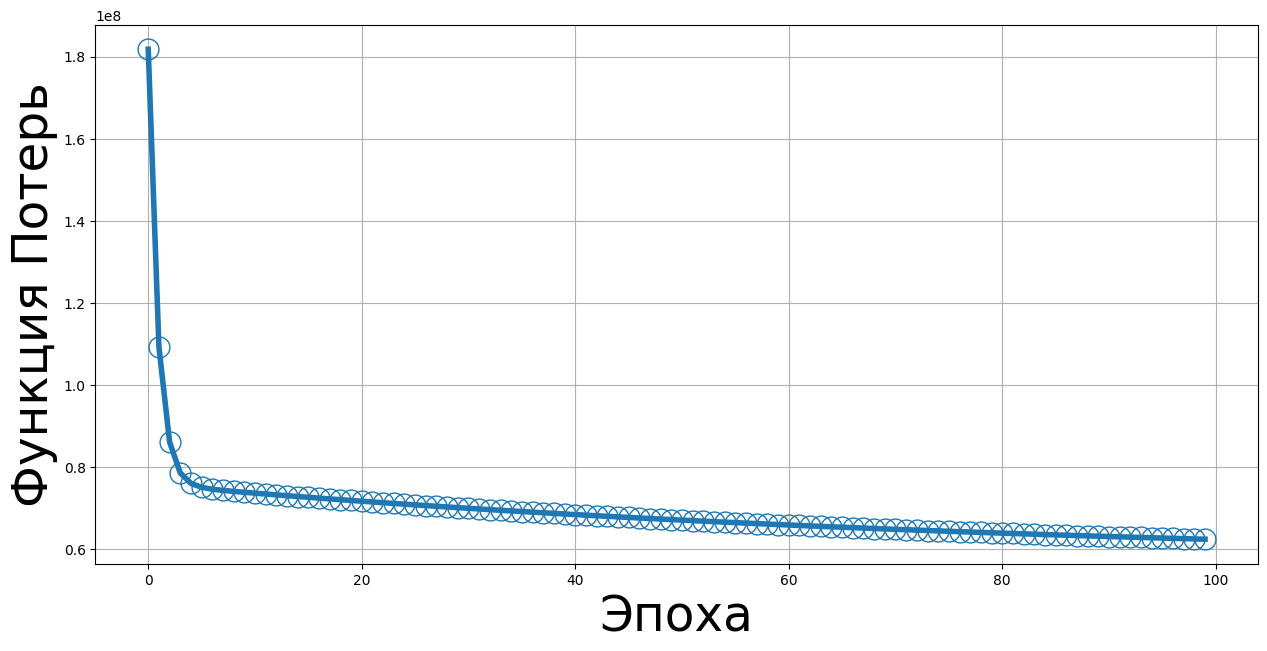

In [286]:
weights = weights_init(X_train.shape[1], random_state=42)
weights, cost = fit(X_train, y_train, weights, lr=0.9,  epochs=100)
fig  = plt.figure(figsize=(15, 7))
plot_cost(cost)

Посмотрим как выглядят наши ответы на фоне реальных

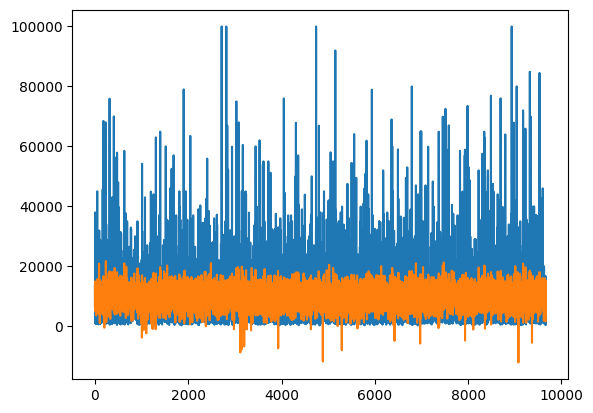

In [287]:
yhat = predict(weights, X_test)
plt.plot(y_test, label='original')
plt.plot(yhat, label='predicted')

Text(0, 0.5, 'predicted')

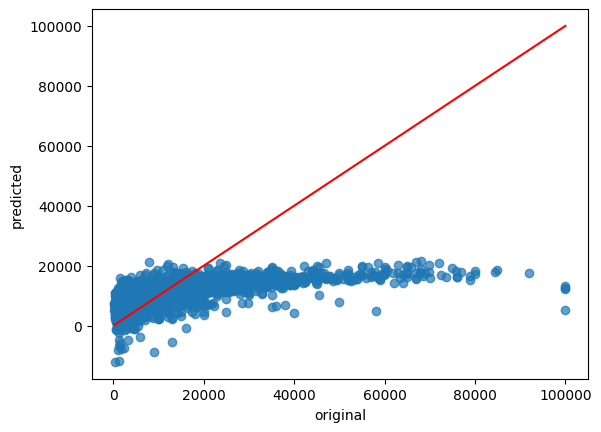

In [288]:
plt.scatter(y_test,yhat,alpha = 0.7)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'r')
plt.xlabel('original')
plt.ylabel('predicted')

In [289]:
# Коэффициент детерменации
r2_score(weights, X_test, y_test)

0.324818580035946

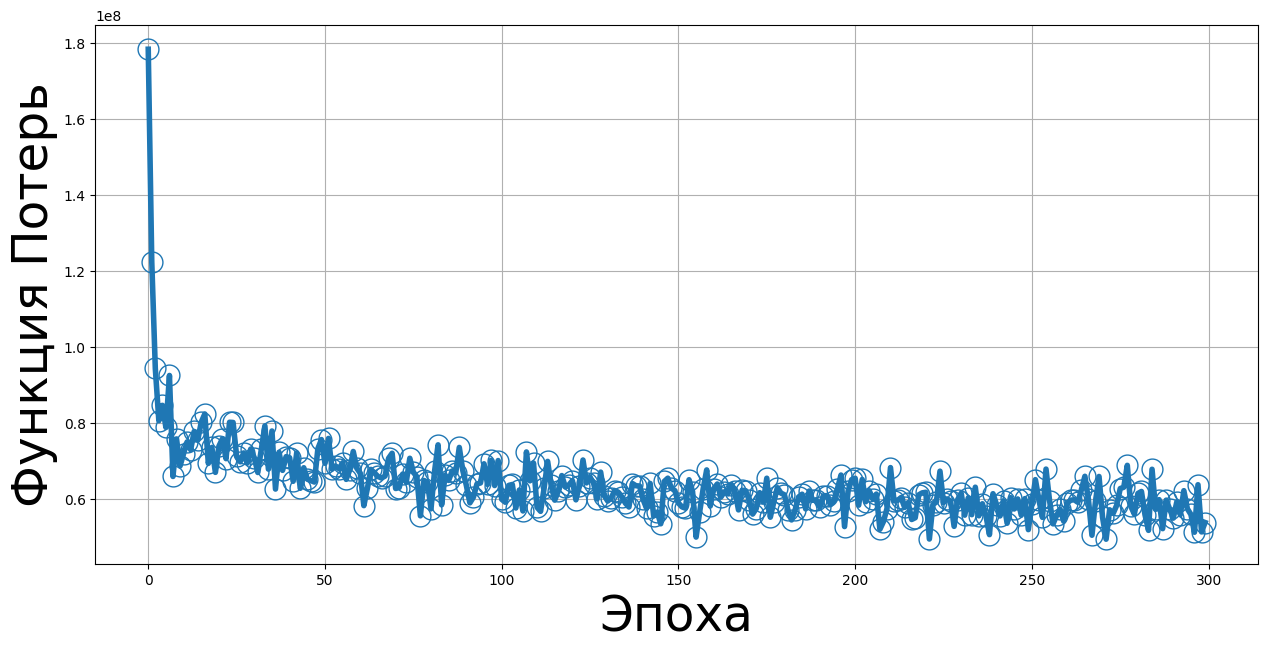

In [290]:
weights = weights_init(X_train.shape[1], random_state=42)
weights, cost = fit_SGD(X_train, y_train, weights, lr=0.7,  epochs=300)
fig  = plt.figure(figsize=(15, 7))
plot_cost(cost)

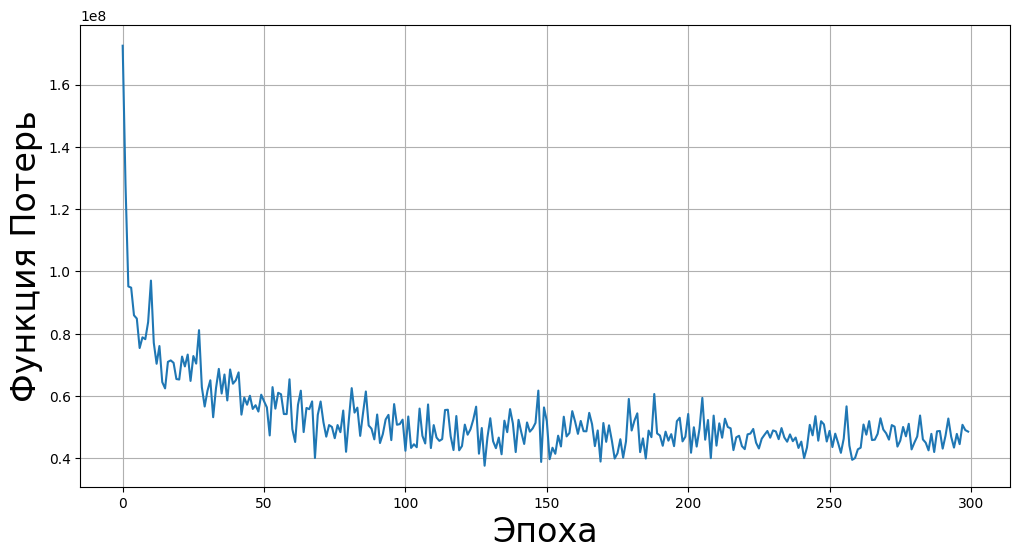

train R2: 0.4848; test R2: 0.4736


In [291]:
regr = LinearRegression(learning_rate=0.5, epochs=300, batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()
print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

**После стандартизации точность немного повысилась**

Визуализруем веса

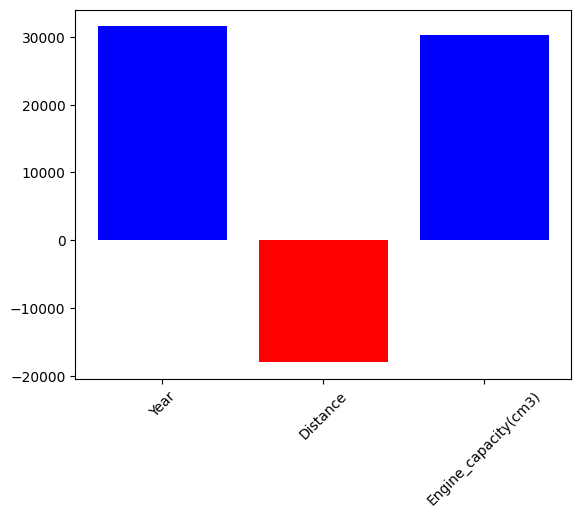

In [292]:
w, b = regr.get_w_and_b()
vis_weigths(w, features_names)

In [293]:
np.sum(np.abs(w))

79911.77796139642

### 4. Данные после One-hot кодирования

In [294]:
df = pd.read_csv('cars_moldova_onehot.csv', delimiter = ',')
df

,Year,Distance,Engine_capacity(cm3),Transmission,Price(euro),Age,km_per_year,Make_Alfa Romeo,Make_Audi,Make_BMW,...,Style_Universal,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,km_per_year_cat_large,km_per_year_cat_medium,km_per_year_cat_small
0,2011,195000.0,1800.0,1,7750.0,11,17727.272727,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,2014,135000.0,1500.0,0,8550.0,8,16875.000000,0,0,0,...,1,1,0,0,0,0,0,0,1,0
2,2012,110000.0,1500.0,0,6550.0,10,11000.000000,0,0,0,...,1,1,0,0,0,0,0,0,1,0
3,2006,200000.0,1600.0,0,4100.0,16,12500.000000,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,2000,300000.0,2200.0,0,3490.0,22,13636.363636,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35112,2002,225000.0,1800.0,0,4400.0,20,11250.000000,0,0,0,...,0,0,0,0,1,0,0,0,1,0
35113,2015,89000.0,1500.0,0,7000.0,7,12714.285714,0,0,0,...,1,1,0,0,0,0,0,0,1,0
35114,2016,50000.0,1950.0,1,29500.0,6,8333.333333,0,0,0,...,0,1,0,0,0,0,0,0,0,1
35115,2006,370000.0,2000.0,0,4000.0,16,23125.000000,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [295]:
cat_columns = []
num_columns = []

for column_name in df.columns:
    if (df[column_name].dtypes == object):
        cat_columns += [column_name]
    else:
        num_columns += [column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))
print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  [] 
 Число столблцов =  0
Числовые данные:	  ['Year', 'Distance', 'Engine_capacity(cm3)', 'Transmission', 'Price(euro)', 'Age', 'km_per_year', 'Make_Alfa Romeo', 'Make_Audi', 'Make_BMW', 'Make_Chevrolet', 'Make_Chrysler', 'Make_Citroen', 'Make_Dacia', 'Make_Daewoo', 'Make_Daihatsu', 'Make_Dodge', 'Make_Fiat', 'Make_Ford', 'Make_GAZ', 'Make_Honda', 'Make_Hyundai', 'Make_Infiniti', 'Make_Jaguar', 'Make_Jeep', 'Make_KIA', 'Make_Land Rover', 'Make_Lexus', 'Make_Lincoln', 'Make_Mazda', 'Make_Mercedes', 'Make_Mini', 'Make_Mitsubishi', 'Make_Nissan', 'Make_Opel', 'Make_Peugeot', 'Make_Porsche', 'Make_Rare_cheap', 'Make_Rare_expensive', 'Make_Renault', 'Make_Rover', 'Make_Seat', 'Make_Skoda', 'Make_Smart', 'Make_Ssangyong', 'Make_Subaru', 'Make_Suzuki', 'Make_Toyota', 'Make_Vaz', 'Make_Volkswagen', 'Make_Volvo', 'Model_100', 'Model_206', 'Model_2106', 'Model_2107', 'Model_2121niva', 'Model_3', 'Model_3 Series', 'Model_307', 'Model_323', 'Model_5 Series', 'Model_6', 'Mo

Разобъем данные на тренировочные и тестовые

In [296]:
df_num = df[num_columns].copy()

df_num.info()

X, y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35117 entries, 0 to 35116
Columns: 219 entries, Year to km_per_year_cat_small
dtypes: float64(4), int64(215)
memory usage: 58.7 MB


,0,1,2,3,4,5,6,7,8,9,...,208,209,210,211,212,213,214,215,216,217
24576,0.775,0.269878,0.365833,0.0,0.225,0.322645,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24577,0.375,0.481580,0.373958,0.0,0.625,0.220749,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
24578,0.750,0.333222,0.270833,0.0,0.250,0.362361,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24579,0.750,0.261544,0.208333,0.0,0.250,0.284023,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24580,0.350,0.309128,0.333333,0.0,0.650,0.135713,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Рассчитаем градиент ошибки

In [297]:
weights = np.random.randn(X.shape[1])
yhat = forward(weights, X_train[0])
print(weights)
grad = grad_loss(yhat, y[0], X[0])
print(grad)

[-1.38264301e-01 -1.27468225e+00  1.91386148e-01 -1.30424901e+00
 -1.10484632e-02  2.27537615e-01  1.28330519e+00 -1.30494564e+00
 -1.01070334e-01 -6.06098592e-01 -8.22839104e-01  9.04450092e-01
 -4.09329097e-01  1.94609237e+00 -5.18891523e-01 -5.93116988e-01
 -1.20061718e+00 -1.01960088e-01  8.51115449e-01  4.52204451e-02
 -6.13062108e-01 -2.60232026e-01  9.89724209e-01  8.86863895e-01
  2.47609576e+00  1.80993312e+00 -5.81590640e-01 -1.14114045e+00
 -3.29963867e-01  8.37693120e-01 -2.18082486e-01 -6.95555264e-01
 -1.44080619e+00 -1.00031285e+00 -1.53846787e-01  8.09716764e-01
  1.70664466e+00  1.30428386e+00  9.48571419e-01  1.71086936e+00
  1.23469387e+00  2.41533119e-01  3.94329664e-01 -1.26333200e+00
  3.71646102e-01  4.98418301e-01 -9.91536538e-01 -9.71882834e-01
  9.56805670e-01 -6.61525087e-01 -2.78625165e-01  7.95352123e-01
 -9.19202109e-01  3.76326841e-01 -1.47316206e+00 -5.00968862e-01
 -4.23110603e-02 -1.64829295e+00 -1.38517395e-01 -1.99481435e+00
 -5.37233981e-01 -5.31003

Обновим параметры регрессии

In [298]:
lerning_rate = 0.01
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[ 1.43005471e+03  1.38679795e+05  1.28032434e+03 -5.93064040e-01
  7.81198622e+00  1.26075975e+04  1.28330519e+00 -1.30494564e+00
 -1.01070334e-01 -6.06098592e-01 -8.22839104e-01  9.04450092e-01
 -4.09329097e-01  1.94609237e+00 -5.18891523e-01 -5.93116988e-01
 -1.20061718e+00 -1.01960088e-01  8.51115449e-01  4.52204451e-02
 -6.13062108e-01 -2.60232026e-01  9.89724209e-01  8.86863895e-01
  2.47609576e+00  1.80993312e+00 -5.81590640e-01 -1.14114045e+00
 -3.29963867e-01  8.37693120e-01 -2.18082486e-01 -6.95555264e-01
 -1.44080619e+00 -1.00031285e+00 -1.53846787e-01  8.09716764e-01
  1.70664466e+00  1.30428386e+00  9.48571419e-01  1.71086936e+00
  1.23469387e+00  2.41533119e-01  3.94329664e-01 -1.26333200e+00
  3.71646102e-01  4.98418301e-01 -2.80351566e-01 -9.71882834e-01
  9.56805670e-01 -6.61525087e-01 -2.78625165e-01  7.95352123e-01
 -9.19202109e-01  3.76326841e-01 -1.47316206e+00 -5.00968862e-01
 -4.23110603e-02 -1.64829295e+00 -1.38517395e-01 -1.99481435e+00
 -5.37233981e-01 -5.31003

Инициализируем веса

In [299]:
weights = weights_init(X_train.shape[1], random_state=42)
weights

array([ 0.03364173, -0.00936444,  0.043867  ,  0.1031526 , -0.01585887,
       -0.01585776,  0.10695779,  0.05197724, -0.03179682,  0.0367468 ,
       -0.03138661, -0.0315432 ,  0.01638775, -0.12958369, -0.11682618,
       -0.03808292, -0.06859758,  0.02128351, -0.06149915, -0.09565328,
        0.09926626, -0.0152915 ,  0.00457359, -0.09649612, -0.03687025,
        0.00751263, -0.07795512,  0.02544548, -0.04068039, -0.01975599,
       -0.04075271,  0.12545211, -0.00091415, -0.07163722,  0.05570977,
       -0.08268597,  0.01414603, -0.13272561, -0.08995611,  0.01333313,
        0.05001527,  0.01160652, -0.00783269, -0.02039332, -0.10013814,
       -0.048754  , -0.03119839,  0.07159735,  0.02327277, -0.11940815,
        0.02194974, -0.02608106, -0.04584694,  0.04142795,  0.0698281 ,
        0.06307425, -0.05683898, -0.0209425 ,  0.02243599,  0.06607225,
       -0.03245377, -0.01257441, -0.07493046, -0.08101734,  0.05503119,
        0.09185617, -0.00487714,  0.06796782,  0.02449308, -0.04

Протестируем обучение

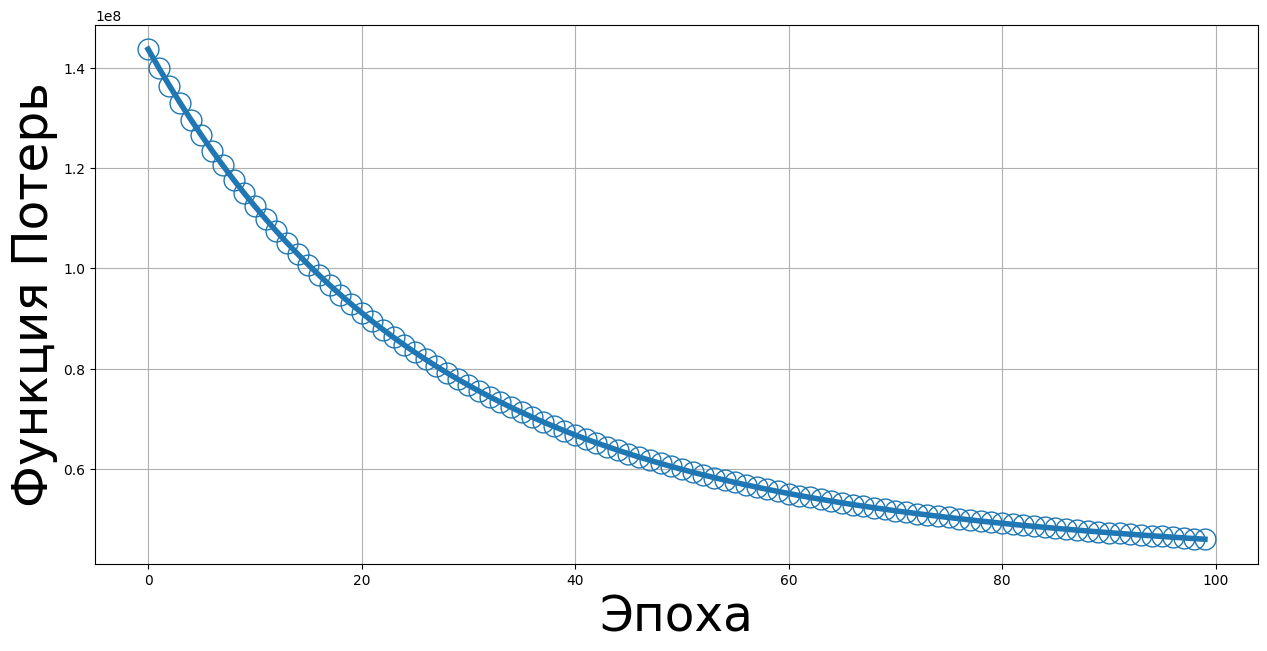

In [300]:
weights = weights_init(X_train.shape[1], random_state=42)
weights, cost = fit(X_train, y_train, weights, lr=0.9,  epochs=100)
fig  = plt.figure(figsize=(15, 7))
plot_cost(cost)

Посмотрим как выглядят наши ответы на фоне реальных

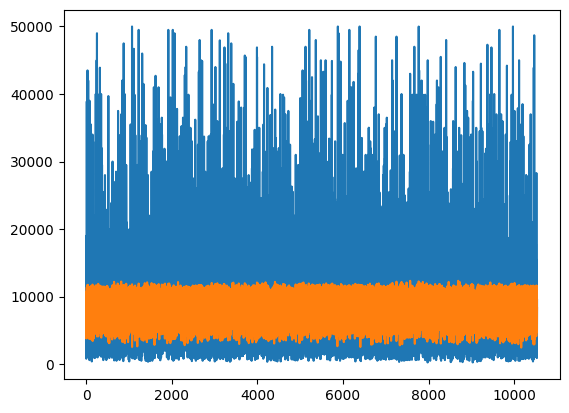

In [301]:
yhat = predict(weights, X_test)
plt.plot(y_test, label='original')
plt.plot(yhat, label='predicted')

Text(0, 0.5, 'predicted')

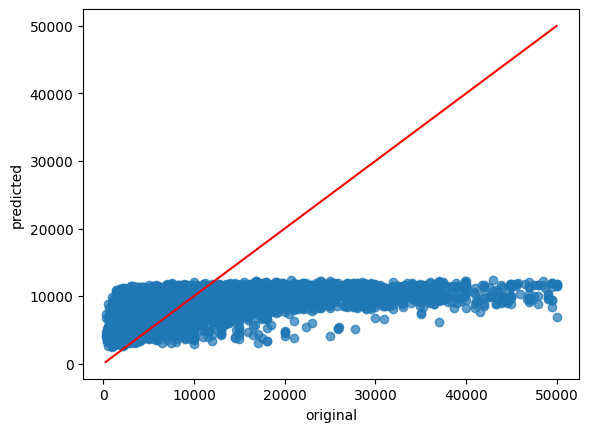

In [302]:
plt.scatter(y_test,yhat,alpha = 0.7)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'r')
plt.xlabel('original')
plt.ylabel('predicted')

In [303]:
# Коэффициент детерменации
r2_score(weights, X_test, y_test)

0.23167380629811318

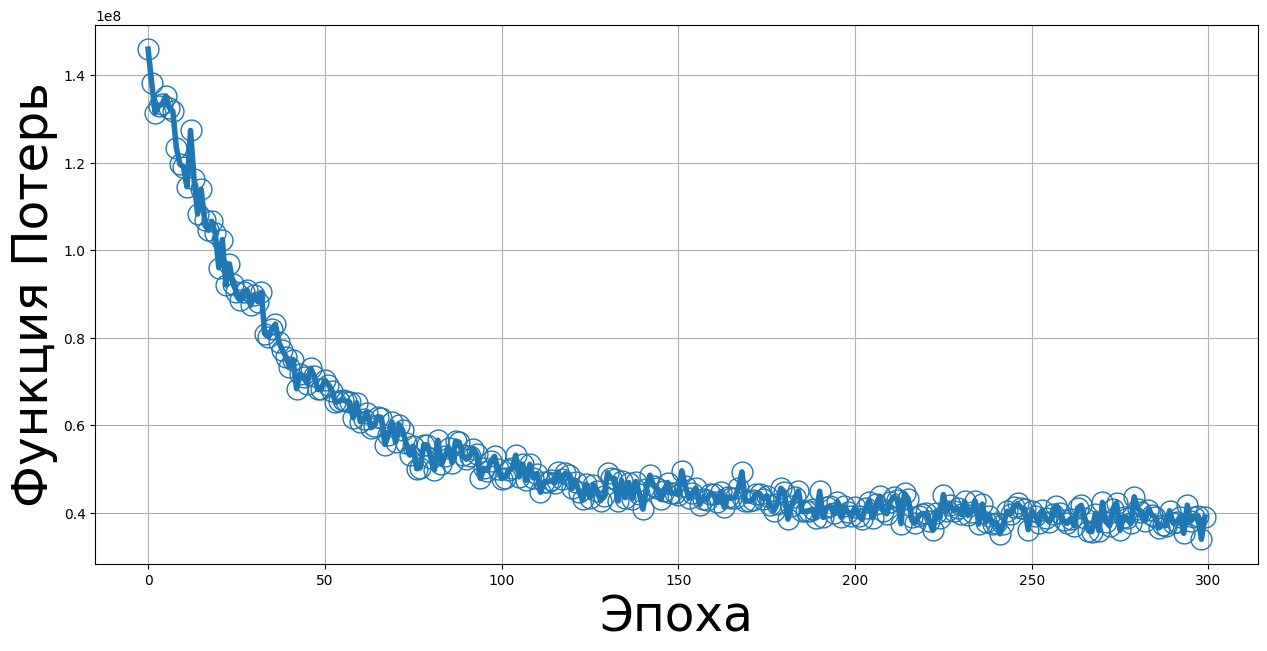

In [304]:
weights = weights_init(X_train.shape[1], random_state=42)
weights, cost = fit_SGD(X_train, y_train, weights, lr=0.7,  epochs=300)
fig  = plt.figure(figsize=(15, 7))
plot_cost(cost)

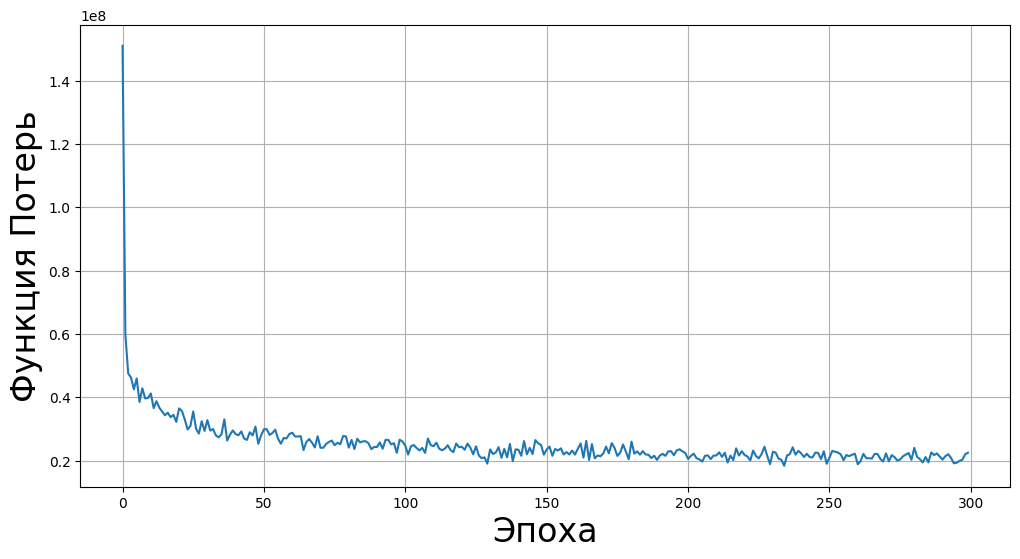

train R2: 0.6529; test R2: 0.6528


In [305]:
regr = LinearRegression(learning_rate=0.1, epochs=300, batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()
print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

**После onehot кодирования точность значительно повысилась**

Визуализруем веса

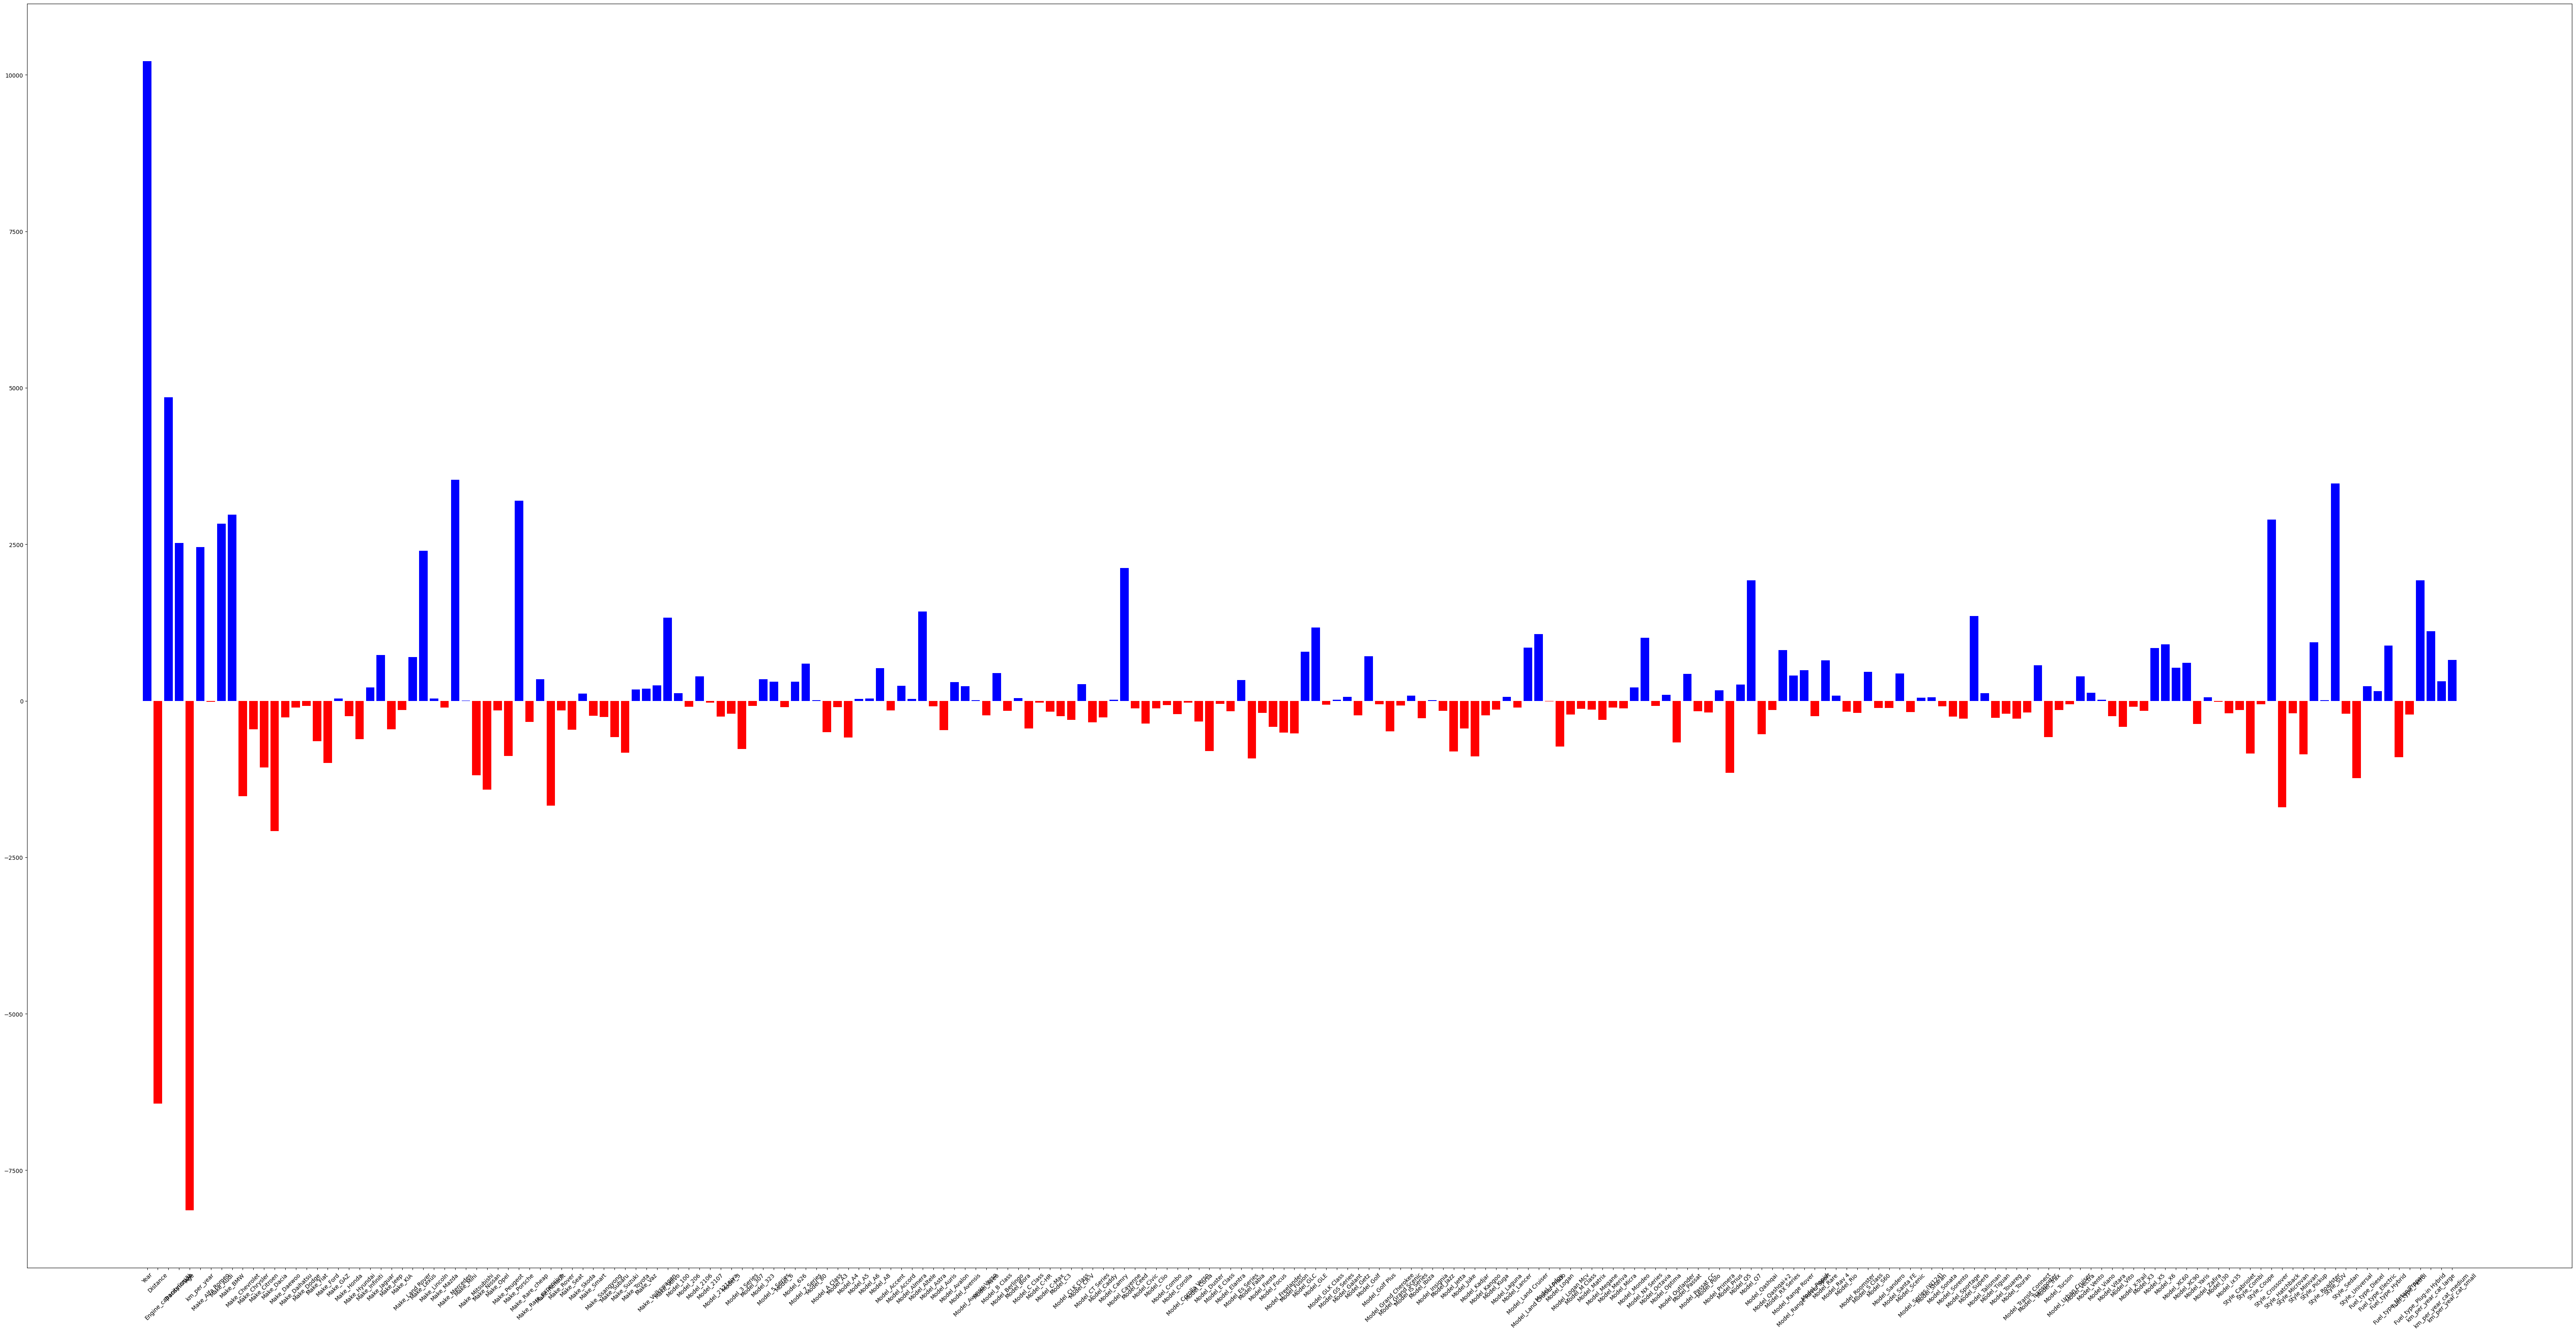

In [306]:
w, b = regr.get_w_and_b()
plt.figure(figsize=(80, 40))
vis_weigths(w, features_names)

In [307]:
np.sum(np.abs(w))

139563.17224618935

### Выводы
- Различные типы предварительной обработки повышают точность регрессии
- one-hot кодирование так же повышает точность
- Самые значимые признаки: Year и Engine_capacity(cm3)